In [1]:
# 迁移学习网络，加载其他新训练好的模型，固化别人训练好的参数


from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [2]:
#训练集数据扩充和归一化
#在验证集上仅需要归一化
#torch可以直接读取 imagenet的数据 注意
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224), #随机裁剪一个area然后再resize
        transforms.RandomHorizontalFlip(), #随机水平翻转,在此扩展训练集
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = "hymenoptera_data"
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


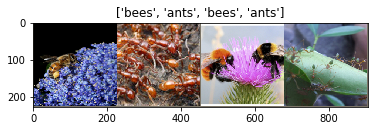

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# 获取一批训练数据
inputs, classes = next(iter(dataloaders['train']))

# 批量制作网格
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # 每个epoch都有一个训练和验证阶段
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # 迭代数据.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 零参数梯度
                optimizer.zero_grad()

                # 前向
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 后向+仅在训练阶段进行优化
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 统计
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # 深度复制mo
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # 加载最佳模型权重
    model.load_state_dict(best_model_wts)
    return model

In [5]:
#一个通用的展示少量预测图片的函数
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [6]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# 观察所有参数都正在优化
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 每7个epochs衰减LR通过设置gamma=0.1
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/wilson/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:28<00:00, 1.62MB/s]


Epoch 0/24
----------


/home/wilson/anaconda3/lib/python3.5/site-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.5705 Acc: 0.7254
val Loss: 0.2747 Acc: 0.8824

Epoch 1/24
----------
train Loss: 0.4983 Acc: 0.7787
val Loss: 0.4749 Acc: 0.8235

Epoch 2/24
----------
train Loss: 0.3998 Acc: 0.8443
val Loss: 0.3655 Acc: 0.8758

Epoch 3/24
----------
train Loss: 0.4298 Acc: 0.8115
val Loss: 0.3509 Acc: 0.8627

Epoch 4/24
----------
train Loss: 0.4609 Acc: 0.8320
val Loss: 0.4180 Acc: 0.8758

Epoch 5/24
----------
train Loss: 0.4846 Acc: 0.8115
val Loss: 0.6448 Acc: 0.7647

Epoch 6/24
----------
train Loss: 0.4996 Acc: 0.8238
val Loss: 0.2489 Acc: 0.9216

Epoch 7/24
----------
train Loss: 0.2495 Acc: 0.9098
val Loss: 0.1961 Acc: 0.9216

Epoch 8/24
----------
train Loss: 0.4037 Acc: 0.8279
val Loss: 0.2113 Acc: 0.9150

Epoch 9/24
----------
train Loss: 0.2931 Acc: 0.8607
val Loss: 0.1925 Acc: 0.9346

Epoch 10/24
----------
train Loss: 0.3006 Acc: 0.8689
val Loss: 0.1872 Acc: 0.9216

Epoch 11/24
----------
train Loss: 0.2810 Acc: 0.8770
val Loss: 0.2064 Acc: 0.9085

Epoch 12/24
----------
t

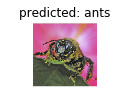

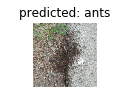

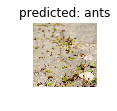

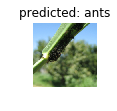

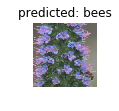

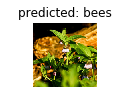

In [7]:
visualize_model(model_ft)